## LSTM部分


开始训练，设备: cuda, 样本数: 144
Epoch [10/1000], Loss: 0.019505
Epoch [20/1000], Loss: 0.015562
Epoch [30/1000], Loss: 0.014631
Epoch [40/1000], Loss: 0.013543
Epoch [50/1000], Loss: 0.014264
Epoch [60/1000], Loss: 0.012620
Epoch [70/1000], Loss: 0.012348
Epoch [80/1000], Loss: 0.012669
Epoch [90/1000], Loss: 0.011951
Epoch [100/1000], Loss: 0.012177
Epoch [110/1000], Loss: 0.011589
Epoch [120/1000], Loss: 0.011678
Epoch [130/1000], Loss: 0.012266
Epoch [140/1000], Loss: 0.013487
Epoch [150/1000], Loss: 0.012945
Epoch [160/1000], Loss: 0.010724
Epoch [170/1000], Loss: 0.011855
Epoch [180/1000], Loss: 0.010817
Epoch [190/1000], Loss: 0.010530
Epoch [200/1000], Loss: 0.009761
Epoch [210/1000], Loss: 0.010082
Epoch [220/1000], Loss: 0.010336
Epoch [230/1000], Loss: 0.009773
Epoch [240/1000], Loss: 0.009005
Epoch [250/1000], Loss: 0.009856
Epoch [260/1000], Loss: 0.011418
Epoch [270/1000], Loss: 0.009711
Epoch [280/1000], Loss: 0.008934
Epoch [290/1000], Loss: 0.010288
Epoch [300/1000], Loss: 0.00

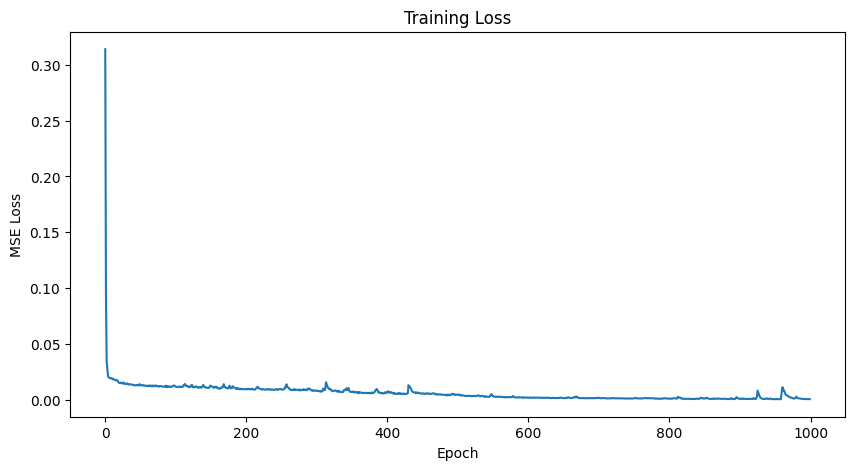


--- 测试预测结果 (第一组数据) ---
预测值 (Acc_x, Acc_y, Acc_z, Steer): [-0.9761641   0.725392   -0.02296302  0.04415198]
真实值 (Acc_x, Acc_y, Acc_z, Steer): [-0.31493804  0.6295083   0.00160047  0.01722461]


In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# ----------------1. 数据准备 ----------------
class VehicleDataset(Dataset):
    def __init__(self, csv_file, seq_length=9):
        self.df = pd.read_csv(csv_file)
        self.seq_length = seq_length

        # 定义输入特征和目标特征
        self.input_cols = [
            'global_x', 'global_y', 'global_z',
            'velocity_x', 'velocity_y', 'velocity_z',
            'steer', 'acceleration_x', 'acceleration_y', 'acceleration_z'
        ]
        self.target_cols = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'steer']

        # 提取数据
        input_data = self.df[self.input_cols].values
        target_data = self.df[self.target_cols].values

        # 归一化 (LSTM 对 0-1 之间的数据更敏感)
        self.scaler_x = MinMaxScaler()
        self.scaler_y = MinMaxScaler()

        self.input_data = self.scaler_x.fit_transform(input_data)
        self.target_data = self.scaler_y.fit_transform(target_data)

    def __len__(self):
        # 必须确保总长度减去序列长度后大于0
        return len(self.input_data) - self.seq_length

    def __getitem__(self, idx):
        # 窗口 [idx : idx + seq_length] 作为输入
        # 第 idx + seq_length 行作为标签
        x = self.input_data[idx : idx + self.seq_length]
        y = self.target_data[idx + self.seq_length]

        return torch.FloatTensor(x), torch.FloatTensor(y)

# ----------------2. LSTM 模型定义 ----------------
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # batch_first=True 意味着输入形状为 (batch, seq, feature)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        # 初始化隐藏状态 (可选，不初始化 PyTorch 会默认为全 0)
        out, _ = self.lstm(x)

        # 取最后一个时间步的输出
        out = self.fc(out[:, -1, :])
        return out

# ----------------3. 训练流程 ----------------
def run_pipeline():
    # 参数设置
    seq_length = 9
    batch_size = 16
    hidden_size = 64
    num_epochs = 1000
    learning_rate = 0.001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载数据
    dataset = VehicleDataset('vehicle_data.csv', seq_length=seq_length)
    if len(dataset) <= 0:
        print("错误：数据集太短，无法构成时间序列。请检查 CSV 行数。")
        return

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 模型实例化 (输入特征10个，输出4个)
    model = LSTM_Model(input_size=10, hidden_size=hidden_size, output_size=4).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # 训练循环
    model.train()
    losses = []
    print(f"开始训练，设备: {device}, 样本数: {len(dataset)}")

    for epoch in range(num_epochs):
        epoch_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            # 前向传播
            outputs = model(x)
            loss = criterion(outputs, y)

            # 反向传播
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}')

    # 绘制 Loss 曲线
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.show()

    # ----------------4. 简单测试示例 ----------------
    model.eval()
    with torch.no_grad():
        # 拿一组数据试一下
        test_x, test_y = dataset[5]
        test_x = test_x.unsqueeze(0).to(device) # 增加 batch 维度 -> (1, 9, 10)
        pred = model(test_x)

        # 反归一化查看实际值
        pred_real = dataset.scaler_y.inverse_transform(pred.cpu().numpy())
        true_real = dataset.scaler_y.inverse_transform(test_y.numpy().reshape(1, -1))

        print("\n--- 测试预测结果 (第一组数据) ---")
        print(f"预测值 (Acc_x, Acc_y, Acc_z, Steer): {pred_real[0]}")
        print(f"真实值 (Acc_x, Acc_y, Acc_z, Steer): {true_real[0]}")

if __name__ == "__main__":
    run_pipeline()

In [ ]:
## 添加了导出 功能

>>> 数据预处理完成，参数已存入 scaler_params.json

开始在 cuda 上训练...
Epoch [10/100], Loss: 0.016071
Epoch [20/100], Loss: 0.015384
Epoch [30/100], Loss: 0.015633
Epoch [40/100], Loss: 0.013961
Epoch [50/100], Loss: 0.014096
Epoch [60/100], Loss: 0.012873
Epoch [70/100], Loss: 0.013452
Epoch [80/100], Loss: 0.012772
Epoch [90/100], Loss: 0.012432
Epoch [100/100], Loss: 0.012101


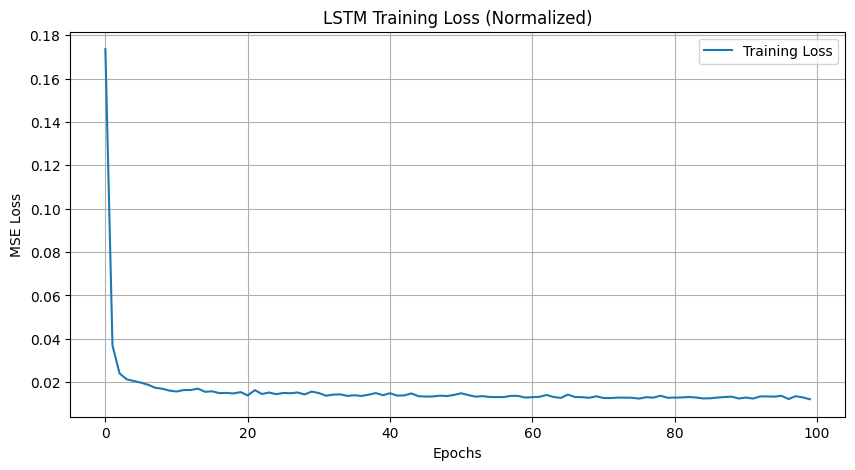


测试样本索引: 84
----------------------------------------
指标名称:    [Acc_X, Acc_Y, Acc_Z, Steer]
模型预测值:  [ 0.2583  0.2685  0.1066 -0.0005]
传感器真值:  [-0.0593  0.6953 -0.0657  0.0105]


In [11]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

# ---------------- 1. 数据预处理、归一化与参数导出 ----------------

def prepare_dataset_and_scaler(input_file, output_csv, scaler_json_path, seq_length=9):
    df = pd.read_csv(input_file)

    # 定义特征和目标列
    input_cols = [
        'global_x', 'global_y', 'global_z',
        'velocity_x', 'velocity_y', 'velocity_z',
        'steer', 'acceleration_x', 'acceleration_y', 'acceleration_z'
    ]
    target_cols = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'steer']
    all_involved = sorted(list(set(input_cols + target_cols)))

    # 归一化
    scaler = MinMaxScaler()
    df_norm = df.copy()
    df_norm[all_involved] = scaler.fit_transform(df[all_involved])

    # 导出归一化参数到 JSON (用于后续还原)
    scaler_params = {}
    for i, col in enumerate(all_involved):
        scaler_params[col] = {
            'min': float(scaler.data_min_[i]),
            'max': float(scaler.data_max_[i])
        }
    with open(scaler_json_path, 'w') as f:
        json.dump(scaler_params, f, indent=4)

    # 构造历史序列数据 (JSON 字符串形式存入列)
    data_list = []
    for i in range(len(df_norm)):
        row_dict = {'target_timestamp': df.iloc[i]['timestamp']}
        indices = [max(0, i - (seq_length - step)) for step in range(seq_length)]

        for col in input_cols:
            history_vals = df_norm.iloc[indices][col].tolist()
            row_dict[f'{col}_history'] = json.dumps(history_vals)

        for col in target_cols:
            row_dict[f'target_{col}'] = df_norm.iloc[i][col]
        data_list.append(row_dict)

    pd.DataFrame(data_list).to_csv(output_csv, index=False)
    print(f">>> 数据预处理完成，参数已存入 {scaler_json_path}")
    return scaler_params

# ---------------- 2. 反归一化函数 ----------------

def inverse_transform(normalized_data, target_names, scaler_params):
    """根据 JSON 中的 min/max 还原原始数值"""
    real_values = []
    for i, col in enumerate(target_names):
        p = scaler_params[col]
        actual_val = normalized_data[i] * (p['max'] - p['min']) + p['min']
        real_values.append(actual_val)
    return real_values

# ---------------- 3. Dataset 与 模型定义 ----------------

class VehicleDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.history_cols = [
            'global_x_history', 'global_y_history', 'global_z_history',
            'velocity_x_history', 'velocity_y_history', 'velocity_z_history',
            'steer_history', 'acceleration_x_history', 'acceleration_y_history', 'acceleration_z_history'
        ]
        self.targets = ['target_acceleration_x', 'target_acceleration_y', 'target_acceleration_z', 'target_steer']

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # 解析 JSON 字符串并转置为 [seq, features]
        x = np.array([json.loads(row[col]) for col in self.history_cols]).T
        y = row[self.targets].values.astype(np.float32)
        return torch.FloatTensor(x), torch.FloatTensor(y)

class VehicleLSTM(nn.Module):
    def __init__(self, input_size=10, hidden_size=128, output_size=4):
        super(VehicleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# ---------------- 4. 训练与可视化主流程 ----------------

def main():
    # 配置
    raw_csv = 'vehicle_data.csv'
    output_csv = 'vehicle_data_history_cols.csv'
    params_json = 'scaler_params.json'
    batch_size = 16
    epochs = 100
    lr = 0.001

    # 步骤 A: 准备数据
    scaler_params = prepare_dataset_and_scaler(raw_csv, output_csv, params_json)

    # 步骤 B: 加载数据
    dataset = VehicleDataset(output_csv)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 步骤 C: 初始化模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = VehicleLSTM().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 步骤 D: 训练循环
    loss_history = []
    print(f"\n开始在 {device} 上训练...")
    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # 前向
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # 后向
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    # 步骤 E: 可视化 Loss 曲线
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history, label='Training Loss')
    plt.title('LSTM Training Loss (Normalized)')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 步骤 F: 验证与反归一化
    model.eval()
    with torch.no_grad():
        # 随机取一组数据展示效果
        sample_idx = np.random.randint(len(dataset))
        test_x, test_y = dataset[sample_idx]

        pred_norm = model(test_x.unsqueeze(0).to(device)).cpu().numpy()[0]

        # 定义目标列名用于 JSON 匹配
        target_names = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'steer']

        # 还原回物理单位
        pred_real = inverse_transform(pred_norm, target_names, scaler_params)
        true_real = inverse_transform(test_y.numpy(), target_names, scaler_params)

        print("\n" + "="*40)
        print(f"测试样本索引: {sample_idx}")
        print("-" * 40)
        print(f"指标名称:    [Acc_X, Acc_Y, Acc_Z, Steer]")
        print(f"模型预测值:  {np.round(pred_real, 4)}")
        print(f"传感器真值:  {np.round(true_real, 4)}")
        print("="*40)

if __name__ == "__main__":
    main()

正在优化模型并开始训练 (设备: cuda)...
Epoch 50/300, Loss: 0.007159, LR: 0.00025
Epoch 100/300, Loss: 0.006219, LR: 6.25e-05
Epoch 150/300, Loss: 0.006175, LR: 3.90625e-06
Epoch 200/300, Loss: 0.006350, LR: 1.220703125e-07
Epoch 250/300, Loss: 0.006128, LR: 1.52587890625e-08
Epoch 300/300, Loss: 0.006219, LR: 1.52587890625e-08


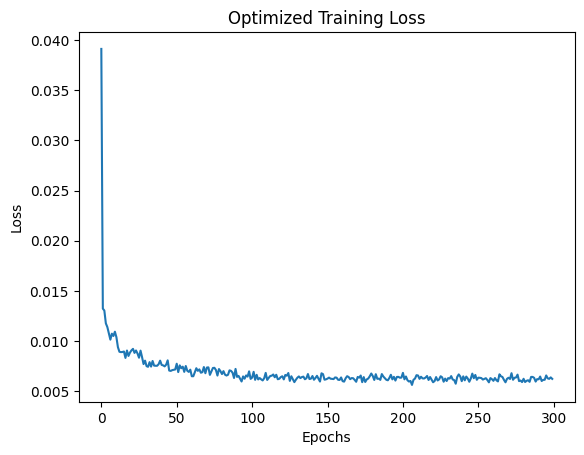


优化后的测试结果 (索引 84):
指标名称: [Acc_X, Acc_Y, Acc_Z, Steer]
优化后预测: [-0.3026 -1.3177 -0.1081 -0.0035]
传感器真值: [-0.0593  0.6953 -0.0657  0.0105]


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler

# ---------------- 1. 数据预处理（逻辑保持一致，增强 JSON 稳定性） ----------------

def prepare_optimized_dataset(input_file, output_csv, scaler_json_path, seq_length=9):
    df = pd.read_csv(input_file)
    input_cols = [
        'global_x', 'global_y', 'global_z',
        'velocity_x', 'velocity_y', 'velocity_z',
        'steer', 'acceleration_x', 'acceleration_y', 'acceleration_z'
    ]
    target_cols = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'steer']
    all_relevant = sorted(list(set(input_cols + target_cols)))

    scaler = MinMaxScaler()
    df_norm = df.copy()
    df_norm[all_relevant] = scaler.fit_transform(df[all_relevant])

    scaler_params = {col: {'min': float(scaler.data_min_[i]), 'max': float(scaler.data_max_[i])}
                     for i, col in enumerate(all_relevant)}

    with open(scaler_json_path, 'w') as f:
        json.dump(scaler_params, f, indent=4)

    data_list = []
    for i in range(len(df_norm)):
        row_dict = {'target_timestamp': df.iloc[i]['timestamp']}
        indices = [max(0, i - (seq_length - step)) for step in range(seq_length)]
        for col in input_cols:
            row_dict[f'{col}_history'] = json.dumps(df_norm.iloc[indices][col].tolist())
        for col in target_cols:
            row_dict[f'target_{col}'] = df_norm.iloc[i][col]
        data_list.append(row_dict)

    pd.DataFrame(data_list).to_csv(output_csv, index=False)
    return scaler_params

# ---------------- 2. 改进的模型架构：Attention + Bi-LSTM ----------------

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size, 1)

    def forward(self, lstm_output):
        # lstm_output: [batch, seq_len, hidden_size]
        attn_weights = F.softmax(self.attn(lstm_output), dim=1)
        # context: [batch, hidden_size]
        context = torch.sum(attn_weights * lstm_output, dim=1)
        return context, attn_weights

class OptimizedVehicleLSTM(nn.Module):
    def __init__(self, input_size=10, hidden_size=256, output_size=4):
        super(OptimizedVehicleLSTM, self).__init__()
        # 双向 LSTM，捕捉序列的前后依赖
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2,
                            batch_first=True, dropout=0.3, bidirectional=True)

        # 注意力层
        self.attention = Attention(hidden_size * 2) # *2 因为是双向

        # 层归一化
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        # 更加深层的预测头
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        lstm_out, _ = self.lstm(x)

        # 归一化提高稳定性
        lstm_out = self.layer_norm(lstm_out)

        # 通过注意力机制融合 9 帧的信息，而不是只看最后一帧
        context, _ = self.attention(lstm_out)

        return self.fc(context)

# ---------------- 3. 数据加载器 ----------------

class VehicleDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.history_cols = [c for c in self.df.columns if '_history' in c]
        self.target_cols = ['target_acceleration_x', 'target_acceleration_y', 'target_acceleration_z', 'target_steer']

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # 按照 input_cols 的顺序还原数据
        x = np.array([json.loads(row[col]) for col in self.history_cols]).T
        y = row[self.target_cols].values.astype(np.float32)
        return torch.FloatTensor(x), torch.FloatTensor(y)

# ---------------- 4. 优化后的训练流程 ----------------

def train_and_evaluate():
    # 配置
    input_csv = 'vehicle_data.csv'
    processed_csv = 'vehicle_data_history_cols.csv'
    params_json = 'scaler_params.json'
    batch_size = 16
    epochs = 300  # 增加训练轮次
    lr = 0.001

    # 准备数据
    scaler_params = prepare_optimized_dataset(input_csv, processed_csv, params_json)
    dataset = VehicleDataset(processed_csv)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = OptimizedVehicleLSTM().to(device)

    # 使用 AdamW 优化器，增加权重衰减防止过拟合
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    # 引入学习率调度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
    criterion = nn.SmoothL1Loss() # 使用 Huber Loss 对异常值更鲁棒，比 MSE 效果更好

    loss_history = []
    print(f"正在优化模型并开始训练 (设备: {device})...")

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            preds = model(batch_x)
            loss = criterion(preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        scheduler.step(avg_loss) # 更新学习率

        if (epoch + 1) % 50 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}, LR: {current_lr}")

    # 绘制损失曲线
    plt.plot(loss_history)
    plt.title("Optimized Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    # 最终验证
    model.eval()
    with torch.no_grad():
        # 随机抽取一个索引进行测试
        test_idx = 84 # 使用你提到的索引 84
        test_x, test_y = dataset[test_idx]
        pred_norm = model(test_x.unsqueeze(0).to(device)).cpu().numpy()[0]

        # 反归一化
        def inv(val_norm, names):
            return [val_norm[i] * (scaler_params[n]['max'] - scaler_params[n]['min']) + scaler_params[n]['min']
                    for i, n in enumerate(names)]

        targets = ['acceleration_x', 'acceleration_y', 'acceleration_z', 'steer']
        pred_real = inv(pred_norm, targets)
        true_real = inv(test_y.numpy(), targets)

        print("\n" + "="*50)
        print(f"优化后的测试结果 (索引 {test_idx}):")
        print(f"指标名称: [Acc_X, Acc_Y, Acc_Z, Steer]")
        print(f"优化后预测: {np.round(pred_real, 4)}")
        print(f"传感器真值: {np.round(true_real, 4)}")
        print("="*50)

if __name__ == "__main__":
    train_and_evaluate()